In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

# define class where each object holds all the data for a fracture toughness test
class ThreePointBend:
    
    def __init__(self, path, S, W, B, cmp=1, E=22.5e3, calc_E=True, start_line=6, multi=False):
        
        self.S = S
        self.W = W
        self.B = B
        self.cmp = cmp
        self._calc_E = calc_E
        self.E = E
        self.m = self.E
        self._multi = multi
        self.plottable_arrays = {}
        self._start_line = start_line
        
        # define all variables to be filled in later
        self.P_max = None
        self.pl_index = None
        self.time_pl = None
        self.crosshead_pl = None
        self.load_pl = None
        self.crosshead_linearized = None
        self.load_linearized = None
        self.stress = None
        self.stress_linearized = None
        self.MOR = None
        self.toughness_overall = None
        self.toughness_stress = None
        
        # cement-mass-normalized values
        self.load_normalized = None
        self.load_pl_normalized = None
        self.load_linearized_normalized = None
        self.stress_normalized = None
        self.stress_linearized_normalized = None
        self.MOR_normalized = None
        self.toughness_overall_normalized = None
        self.toughness_stress_normalized = None
        
        # read data
        self.data = pd.read_csv(path, skiprows=self._start_line)
        self.data = self.data.drop([0])
        
        # get relevant columns and preprocess
        self.time = self.data.loc[:, 'Time '].to_numpy(dtype=np.double)
        self.crosshead = self.data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
        self.load = self.data.loc[:, 'Load '].to_numpy(dtype=np.double)
        self.preprocess()
        
    def preprocess(self):
        self.crosshead = abs(self.crosshead)
        self.load = abs(self.load)
        
        
    # show peak values
    def display_peaks(self):
        peaks, _ = find_peaks(self.load, width=10)

        print(peaks)

        plt.plot(self.crosshead, self.load)
        plt.plot(self.crosshead[peaks], self.load[peaks], 'x')
        plt.show()


    def do_analysis(self, pl_index, stop_index=None):
        
        if (stop_index is not None and stop_index < pl_index):
            raise Exception("stop_index must be greater than pl_index")

        # set peak index and find max load
        self.pl_index = pl_index
        self.P_max = np.max(self.load)

        # make post-peak arrays
        self.crop_arrays(stop_index=stop_index)

        # once peak is found, calculate E using slope (or not)
        if (self._calc_E == True):
            self.E = self.get_E_reg()

        # after E is found, we can linearize the load pre-peak using the calculated slope
        self.crosshead_linearized, self.load_linearized = self.linearize_load(self._calc_E)
        self.plottable_arrays['crosshead_linearized'] = self.crosshead_linearized
        self.plottable_arrays['load_linearized'] = self.load_linearized
        
        # get stress
        self.get_stresses()
        
        # find MOR
        self.MOR = self.get_MOR()
        
        # find toughnesses
        self.toughness_overall, self.toughness_stress = self.get_toughness()
       
        
        # normalize all values with cement mass percent
        self.load_normalized = self.load / self.cmp
        self.load_pl_normalized = self.load_pl / self.cmp
        self.load_linearized_normalized = self.load_linearized / self.cmp
        self.stress_normalized = self.stress / self.cmp
        self.stress_linearized_normalized = self.stress_linearized / self.cmp
        self.MOR_normalized = self.MOR / self.cmp
        self.toughness_overall_normalized = self.toughness_overall / self.cmp
        self.toughness_stress_normalized = self.toughness_stress / self.cmp
        
        # then add to dictionary
        self.plottable_arrays['load_normalized'] = self.load_normalized
        self.plottable_arrays['load_pl_normalized'] = self.load_pl_normalized
        self.plottable_arrays['load_linearized_normalized'] = self.load_linearized_normalized
        self.plottable_arrays['stress_normalized'] = self.stress_normalized
        self.plottable_arrays['stress_linearized_normalized'] = self.stress_linearized_normalized
       
    
    def crop_arrays(self, stop_index=None):
        
        # find proper stop point
        end = None
        if (self._multi == True): end = stop_index - self._start_line
        else:
            # stop at 20% of peak load for non multi-material samples
            load_thresh = 0.2 * self.P_max
            indices_sub_thresh = np.where(self.load[self.pl_index:] <= load_thresh)[0]
            end = indices_sub_thresh[0] + self.pl_index
        
        
        # start cropping
        self.time = self.time[0:end]
        self.crosshead = self.crosshead[0:end]
        self.load = self.load[0:end]
        
        # add to plotting dictionary
        self.plottable_arrays['time'] = self.time
        self.plottable_arrays['crosshead'] = self.crosshead
        self.plottable_arrays['load'] = self.load
        
        # post-peak arrays
        self.time_pl = self.time[self.pl_index:]
        self.crosshead_pl = self.crosshead[self.pl_index:]
        self.load_pl = self.load[self.pl_index:]
        
        # add to plotting dictionary
        self.plottable_arrays['time_pl'] = self.time_pl
        self.plottable_arrays['crosshead_pl'] = self.crosshead_pl
        self.plottable_arrays['load_pl'] = self.load_pl
        
    def get_E_reg(self):
        #  find slope of linear load-displacement region
        num_reg_points = int(self.pl_index / 5)
        crosshead_reg = self.crosshead[self.pl_index-num_reg_points:self.pl_index]
        load_reg = self.load[self.pl_index-num_reg_points:self.pl_index]
        A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
        self.m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]
        
        # use to calculate E
        return (self.S**3 * self.m) / (4*self.B*self.W**3)
        
    
    def linearize_load(self, calc_E):
        # find slope if E was never calculated
        if (calc_E == False):
            num_reg_points = int(self.pl_index / 5)
            crosshead_reg = self.crosshead[self.pl_index-num_reg_points:self.pl_index]
            load_reg = self.load[self.pl_index-num_reg_points:self.pl_index]
            A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
            self.m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]
            
        crosshead_peak = self.crosshead[self.pl_index]
        load_peak = self.load[self.pl_index]

        # generate new data values where lead-up to peak is linearized
        crosshead_x_int = crosshead_peak - (load_peak/self.m)

        crosshead_peak = self.crosshead[self.pl_index]
        crosshead_el = np.linspace(0, crosshead_peak-crosshead_x_int, num=self.pl_index)
        load_el = self.m * np.copy(crosshead_el)
        
        # concatenate to post-peak data
        crosshead_linearized = np.concatenate((crosshead_el, self.crosshead_pl-crosshead_x_int))
        load_linearized = np.concatenate((load_el, self.load_pl))

        return np.copy(crosshead_linearized), np.copy(load_linearized)
    
    def get_stresses(self):
        self.stress = 3*self.load*self.S/(2*self.B*self.W**2)
        self.stress_linearized = 3*self.load_linearized*self.S/(2*self.B*self.W**2)
        
        # add to plotting dictionary
        self.plottable_arrays['stress'] = self.stress
        self.plottable_arrays['stress_linearized'] = self.stress_linearized
    
    def get_MOR(self):
        return self.P_max*self.S/(self.B*self.W**2)
        
    def get_toughness(self):
        toughness_overall = np.trapz(self.load_linearized, x=self.crosshead_linearized)
        toughness_stress = np.trapz(self.stress_linearized, x=self.crosshead_linearized)
        return toughness_overall, toughness_stress
    
        
    def plot(self, x, y, sub, c=None, mc=None):
        x_array = self.plottable_arrays[x]
        y_array = self.plottable_arrays[y]
        
        s = [20*2**n for n in range(len(x_array))]
        
        sub.plot(x_array, y_array, color=c, markerfacecolor=mc, markeredgewidth=0, marker='.', markersize=5)


        

In [44]:
flexural_solid_2 = ThreePointBend('Thesis_Samples_Data/Flexural_solid_2/Flexural_Solid_2.csv', 90, 26.37, 39.97)

[1025 2034]


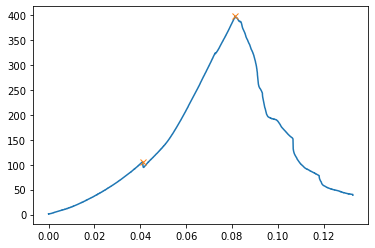

In [45]:
flexural_solid_2.display_peaks()

In [46]:
flexural_solid_2.do_analysis(2034)

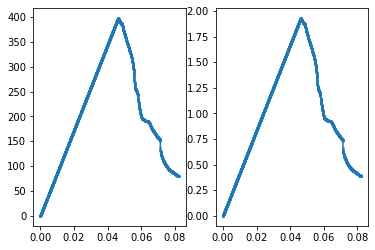

In [47]:
sub = plt.subplot(1, 2, 1)
flexural_solid_2.plot('crosshead_linearized', 'load_linearized_normalized', sub)

sub = plt.subplot(1, 2, 2)
flexural_solid_2.plot('crosshead_linearized', 'stress_linearized_normalized', sub)

In [51]:
print(flexural_solid_2.MOR)
print(flexural_solid_2.toughness_overall)
print(flexural_solid_2.MOR_normalized)
print(flexural_solid_2.toughness_stress)
print(flexural_solid_2.toughness_stress_normalized)

1.2866440730202213
16.639862763856865
1.2866440730202213
0.08082190836952949
0.08082190836952949
